# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [61]:
# Check the present working directory
!pwd

Der Befehl "pwd" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


### Download the data
If you do not have the required **data/** directory in your workspace, follow the instructions below. Use either one of the methods below. 

**Method 1** <br/>
You must [download this dataset](https://video.udacity-data.com/topher/2024/August/66b9ba05_arvato_data.tar/arvato_data.tar.gz) from the Downloads section in the classroom, and upload it into the workspace. After you upload the tar file to the present working  directory, **/workspace/cd1971 Data Scientist Capstone/Bertelsmann_Arvato Project Workspace/**,  in the Jupyter server, you can open a terminal and the run the following command to extract the dataset from the compressed file. 
```bash
!tar -xzvf arvato_data.tar.gz
```
This command will extract all the contents of arvato_data.tar.gz into the current directory. 

**Method 2** <br/>
Execute the Python code below to download the dataset. 


import requests
import tarfile
import os


def download_and_extract(url, extract_to='.'):
    """
    Downloads a tar.gz file from a URL and extracts it to a directory.
    Args:
    - url (str): URL of the tar.gz file to download.
    - extract_to (str): Directory path to extract the contents of the tar.gz file.
    """
    # Get the filename from the URL
    filename = url.split('/')[-1]

    # Download the file
    print("Downloading the file...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.raw.read())
        print("Download completed.")
    else:
        print("Failed to download the file.")
        return

    # Extract the tar.gz file
    print("Extracting the file...")
    try:
        with tarfile.open(filename, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        print("Extraction completed.")
    except Exception as e:
        print(f"Failed to extract the file: {e}")
    finally:
        # Optionally remove the tar.gz file after extraction
        os.remove(filename)
        print("Downloaded tar.gz file removed.")

# URL of the tar.gz file
url = 'https://video.udacity-data.com/topher/2024/August/66b9ba05_arvato_data.tar/arvato_data.tar.gz'

# Call the function with the URL
download_and_extract(url)




### Important Note
>Delete the **data/** folder and the downloaded tar file, before you submit your code. The current workspace cannot save the files beyond 1GB of space in total. 


### Import the Packages

In [62]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

>Note: If you experience "Kernel died" issue while running the codeblock below, then load less number of rows from the .csv files.

In [63]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\GSQOQWI\AppData\Local\Temp\1\ipykernel_23476\4183925281.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
C:\Users\GSQOQWI\AppData\Local\Temp\1\ipykernel_23476\4183925281.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')


In [64]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [65]:
print(azdias.head())

      LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   NaN                  NaN  ...   
1          NaN          NaN                  21.0                 11.0  ...   
2          NaN          NaN                  17.0                 10.0  ...   
3          NaN          NaN                  13.0                  1.0  ...   
4          NaN          NaN                  14.0                  3.0  ...   

   VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0  NaN       NaN         

In [66]:
print(customers.head())

      LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                  10.0                  1.0  ...   
1          NaN          NaN                   NaN                  NaN  ...   
2          NaN          NaN                   0.0                  1.0  ...   
3          NaN          NaN                   8.0                  0.0  ...   
4          NaN          NaN                  14.0                  7.0  ...   

   VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  \
0      2.0             6.0      

**Data Cleaning - Umcodieren Spezieller Werte in NaN**

Schritt 1:

Es gilt anhand des Attribut-Mappings in der Datei DIAS Attributes - Values 2017.xlsx folgendes herauszufinden:

Pro Spalte: Welcher Zahlenwert repräsentiert einen "unknown"-Value in dieser Spalte.

Theoretisches Vorgehen:

Iteration durch die Spalte E
    Wenn String in Spalte E (row X) entweder "unknown" oder "no" [...] "known"
        Dann: füge Wert in D (row X) zu einer Liste hinzu

Gebe am Ende alle Werte dieser Liste aus um zu sehen, welche Zahlenwerte mit unknown/no known gemappt werden.

In [67]:
#Diese Funktion findet im Meta-File DIAS Attributes - Values 2017.xlsx diejenigen Zahlenwerte, die für unknown / no transaction known stehen:

def find_unknown_values(file_path):
    """
    Find the numerical values that represent 'unknown' or 'no ... known' in the specified Excel file.
    
    INPUT:
    file_path - (str) the path to the Excel file
    
    OUTPUT:
    unknown_values - (list) a list of values that represent 'unknown' or 'no ... known' in the dataset
    """
    # Load the Excel file
    df = pd.read_excel(file_path, sheet_name=0)  # Adjust the sheet name if needed
    
    # Access the columns by their position (column E is at index 4, considering 0-based indexing)
    attribute_meaning_col = df.iloc[:, 4]  # Column E
    attribute_value_col = df.iloc[:, 3]    # Column D (index 3)

    # Initialize an empty list to store 'unknown' values
    unknown_values = []

    # Iterate through the rows of the DataFrame
    for index, meaning in attribute_meaning_col.items():
        # Check if the description in column E contains 'unknown' or 'no ... known'
        if isinstance(meaning, str):
            meaning_lower = meaning.lower()
            if 'unknown' in meaning_lower or re.search(r'no .* known', meaning_lower):
                # Add the value from column D to the list
                unknown_values.append(attribute_value_col.iloc[index])
    
    # Return unique 'unknown' values
    return list(set(unknown_values))

# Beispielnutzung
file_path = 'DIAS Attributes - Values 2017.xlsx'  # Pfad zur Excel-Datei anpassen
unknown_values = find_unknown_values(file_path)
print("Values which represent 'unknown' in DIAS Attributes - Values 2017:", unknown_values)



Values which represent 'unknown' in DIAS Attributes - Values 2017: [0, '-1', 10, '-1, 9', '-1, 0', -1]


Gegencheck/Crosscheck:

Folgende Werte reptäsentieren laut find_unknown_values() die unknown-Werte jeder Spalte:
[0, 10, -1, '-1', '-1, 0', '-1, 9']

Um Sicher zu gehen, prüfen wir jetzt die Spalte D nach den Werten [0, 10, -1, '-1', '-1, 0', '-1, 9'] und schauen, ob in der Spalte E Text steht, der auf einen unknown-Wert hindeutet und somit später durch NaN ersetzt werden muss.

Damit schließen wir aus, dass wir in bestimmten Spalten die Values [0, 10, -1, '-1', '-1, 0', '-1, 9'] als NaN setzen, obwohl diese eine andere Bedeutung haben.

Prozessuales Vorgehen:

Wir iterieren durch die Spalte D und prüfen jeweils pro Row auf die Werte [0, 10, -1, '-1', '-1, 0', '-1, 9'].

Wir lassen uns Pro Wert die unique values aus E dazu speichern.

Danach definieren wir Kombinationen aus Value + Text die dazu führen, dass wir einen Wert als 'unknown' einstufen.

Wenn wir eine Kombination aus Value + Text gefunden haben, die unknown/nan entspricht, ermitteln wir dazu das Enstprechende Attribut.

Dann speichern wir das Attribut als Zeile in eine Matrix.

Dann setzen wir eine 1 in der jeweiligen Attributszeile, wo der Value = dem Value in der Spalte entspricht.

Dann Strippen wir die Strings in der Matrix in einzelne Integers.

Also: Wenn Wert in D = -1 und Text in E dazu = 'unknown' Dann ermittle das zugehörige Attribut/Spalte im Dataset.

Wenn bei Attribut "Ager_TYP" im Spale -1 eine 1 steht, ist bei diesem Attribut der Wert -1 als NaN zu konvertieren.



In [68]:

def find_values_in_column_d(file_path, check_values):
    """
    Iterate through column D and check for specific values. Store unique texts from column E for each found value.
    
    INPUT:
    file_path - (str) the path to the Excel file
    check_values - (list) a list of values to check in column D
    
    OUTPUT:
    value_text_map - (dict) a dictionary where keys are the values found in column D and values are sets of unique
                     texts from column E associated with those values
    """
    # Load the Excel file
    df = pd.read_excel(file_path, sheet_name=0)  # Adjust the sheet name if needed
    
    # Access columns D and E
    attribute_value_col = df.iloc[:, 3]  # Column D
    attribute_meaning_col = df.iloc[:, 4]  # Column E
    
    # Initialize a dictionary to store found values and their associated unique texts from column E
    value_text_map = {value: set() for value in check_values}

    # Iterate through the rows of the DataFrame
    for value, meaning in zip(attribute_value_col, attribute_meaning_col):
        if value in check_values:
            # Store the unique text from column E associated with the value in column D
            value_text_map[value].add(meaning)
    
    return value_text_map

# Example usage
file_path = 'DIAS Attributes - Values 2017.xlsx'  # Path to the Excel file
check_values = [0, 10, -1, '-1', '-1, 0', '-1, 9']
value_text_map = find_values_in_column_d(file_path, check_values)

if value_text_map:
    print("Values in column D and their unique texts from column E:")
    for val, texts in value_text_map.items():
        print(f"Value: {val}")
        print(f"Unique texts from column E: {texts}")
else:
    print("No matches found.")



Values in column D and their unique texts from column E:
Value: 0
Unique texts from column E: {'unknown / no main age detectable', 'no 6-10 family homes', 'no company in the building', 'classification not possible', 'no transactions known', 'no score calculated', 'none', 'unknown', 'no small office/home office', "doesn't belong to the green avantgarde", 'no 1-2 family homes', 'no 3-5 family homes', 'no Online-transactions within the last 12 months', 'no transaction known', 'no >10 family homes', 'external supplied hedonists ', 'no classification possible'}
Value: 10
Unique texts from column E: {'01.01.1940 bis 31.12.1944', 'wealthy single homeowners', 'no transactions known', 'Connoisseurs', 'two-generational household', 'top earners ', nan, 'low-income- and average earners of higher age from mulitperson households', '80ies - Generation Golf (Mainstream, W)', '100% Online-transactions within the last 12 months'}
Value: -1
Unique texts from column E: {'unknown'}
Value: -1
Unique texts f

***Mapping Value & Text = NaN***

Wenn Value = 0 und
Text = ('classification not possible', 'none', 'unknown', 'no classification possible', 'unknown / no main age detectable', 'no transaction known', 'no transactions known', 'no score calculated')
Dann: Füge das Attrubut in Spalte B zur Matrix hinzu und setze 1 in der Spalte mit Wert 0

Wenn Value = 10 und
Text = (nan, 'no transactions known')
Dann: Füge das Attrubut in Spalte B zur Matrix hinzu und setze 1 in der Spalte mit Wert 10

Wenn Value = '-1' oder -1 und
Text = ('unknown')
Dann: Füge das Attribut in Spalte B zur Matrix hinzu und setze 1 in der Spalte mit Wert -1 

Wenn Value = '-1, 0' und
Text = ('unknown')
Dann: Füge das Attribut in Spalte B zur Matrix hinzu und setze 1 in der Spalte mit Wert -1 und 0

Wenn Value = '-1, 9' und
Text = ('unknown')
Dann: Füge das Attribut in Spalte B zur Matrix hinzu und setze 1 in der Spalte mit Wert -1 und 9

Zuerst erstellen wir eine leere Matrix mit den Features [-1, 0, 9, 10]

In [69]:
# Create a list of attribute names and ensure they are strings
attribute_names = [str(attr) for attr in azdias.columns.tolist()]

features = [0, -1, 10, '-1, 9', '-1, 0']

# Create an empty DataFrame matrix with attributes as rows and features as columns
nan_mapping_matrix = pd.DataFrame(index=attribute_names, columns=features)

# Initialize the matrix with NaN values (default empty state)
nan_mapping_matrix[:] = pd.NA

# **Normalize the index of nan_mapping_matrix** and convert to strings
#nan_mapping_matrix.index = nan_mapping_matrix.index.astype(str).str.strip().str.upper()

nan_mapping_matrix.index = nan_mapping_matrix.index.astype('string')

# Print the data type of the index to verify it's now a string type
print(nan_mapping_matrix.index.dtype)


string


### Vorgehensweise zur Erstellung der `nan_mapping_matrix`

1. **Datei einlesen**
   - Lese die Datei *DIAS Attributes - Values 2017.xlsx* in einen DataFrame ein, um die relevanten Daten in den Spalten D (Attribut-Werte), E (Bedeutung) und B (Attribut-Namen) zu analysieren.

2. **Überprüfung der Spalte D auf den Wert 0**
   - Iteriere durch alle Zeilen des DataFrames und prüfe, ob der Wert in Spalte D `0` ist.
   - Falls der Wert `0` ist, prüfe den zugehörigen Text in Spalte E.

3. **Bedingung für den Text in Spalte E**
   - Falls der Text in Spalte E einer der folgenden Werte ist:
     - 'classification not possible'
     - 'none'
     - 'unknown'
     - 'no classification possible'
     - 'unknown / no main age detectable'
     - 'no transaction known'
     - 'no transactions known'
     - 'no score calculated'
   - Gehe zur Überprüfung von Spalte B (Attribut-Name) über.

4. **Überprüfung der Spalte B und Eintrag in die `nan_mapping_matrix`**
   - **Wenn ein Wert in Spalte B vorhanden ist**:
     - Suche diesen Wert in den Zeilen der `nan_mapping_matrix`.
     - Falls der Wert gefunden wird, trage in der Spalte `0` der `nan_mapping_matrix` den Wert `1` ein.
     - Falls der Wert nicht gefunden wird, gib eine Warnung aus: *"Spalte [Attribut] in Mapping-Matrix nicht gefunden."*
   - **Wenn kein Wert in Spalte B vorhanden ist (Spalte B leer)**:
     - Gehe in Spalte D so viele Zeilen nach oben, bis ein Wert in Spalte B gefunden wird.
     - Prüfe den gefundenen Wert:
       - Falls der Wert in der `nan_mapping_matrix` vorhanden ist, trage in der Spalte `0` den Wert `1` ein.
       - Falls der Wert nicht vorhanden ist, gib eine Warnung aus: *"Spalte [Attribut] in Mapping-Matrix nicht gefunden."*

5. **Wiederholung für weitere Szenarien**
   - **Für den Wert `0`**:
     - Wenn der Text in Spalte E einer der oben genannten Texte ist, füge das Attribut aus Spalte B zur Matrix hinzu und setze in der Spalte `0` den Wert `1`.
   - **Für den Wert `10`**:
     - Wenn der Text in Spalte E `NaN` oder 'no transactions known' ist, füge das Attribut zur Matrix hinzu und setze in der Spalte `10` den Wert `1`.
   - **Für den Wert `-1` oder `'-1'`**:
     - Wenn der Text in Spalte E 'unknown' ist, füge das Attribut zur Matrix hinzu und setze in der Spalte `-1` den Wert `1`.
   - **Für den Wert `'-1, 0'`**:
     - Wenn der Text in Spalte E 'unknown' ist, füge das Attribut zur Matrix hinzu und setze in den Spalten `-1` und `0` den Wert `1`.
   - **Für den Wert `'-1, 9'`**:
     - Wenn der Text in Spalte E 'unknown' ist, füge das Attribut zur Matrix hinzu und setze in den Spalten `-1` und `9` den Wert `1`.

### Ziel
Dieser Prozess hilft dabei, alle Zahlenwerte in den Attributen zu identifizieren, die in der `nan_mapping_matrix` als `NaN` interpretiert werden sollten, basierend auf den spezifischen Bedingungen und Textbeschreibungen in der Excel-Datei.


In [70]:
import pandas as pd

# Load the Excel file into a DataFrame
file_path = 'DIAS Attributes - Values 2017.xlsx'
df = pd.read_excel(file_path, sheet_name=0)  # Adjust the sheet name if necessary

# Text conditions for marking values as NaN
text_conditions_zero = [
    'classification not possible', 'none', 'unknown',
    'no classification possible', 'unknown / no main age detectable',
    'no transaction known', 'no transactions known', 'no score calculated'
]

text_conditions_ten = ['no transactions known']
text_conditions_negative_one = ['unknown']
text_conditions_negative_one_zero = ['unknown']
text_conditions_negative_one_nine = ['unknown']

# Iterate over each row in the DataFrame
for idx, row in df.iterrows():
    # Extract values based on column indices (assume D is index 3, E is index 4, B is index 1)
    value_d = row.iloc[3]  # Column D
    text_e = row.iloc[4]  # Column E
    attribute_b = str(row.iloc[1]).strip().upper()  # Column B, converted to uppercase string
    
    # Check if value in column D is 0 and text in column E matches the conditions
    if value_d == 0:
        if pd.isna(text_e) or text_e in text_conditions_zero:
            if pd.notna(attribute_b):
                # Add the attribute to the matrix if not present
                if attribute_b not in nan_mapping_matrix.index:
                    nan_mapping_matrix.loc[attribute_b] = pd.NA
                nan_mapping_matrix.at[attribute_b, 0] = 1

    # Repeat similar checks for value 10
    elif value_d == 10:
        if pd.isna(text_e) or text_e in text_conditions_ten:
            if pd.notna(attribute_b):
                if attribute_b not in nan_mapping_matrix.index:
                    nan_mapping_matrix.loc[attribute_b] = pd.NA
                nan_mapping_matrix.at[attribute_b, 10] = 1

    # Check for value -1
    elif (value_d == '-1' or value_d == -1):
        if pd.isna(text_e) or text_e in text_conditions_negative_one:
            if pd.notna(attribute_b):
                if attribute_b not in nan_mapping_matrix.index:
                    nan_mapping_matrix.loc[attribute_b] = pd.NA
                nan_mapping_matrix.at[attribute_b, -1] = 1

    # Check for value '-1, 0'
    elif value_d == '-1, 0':
        if pd.isna(text_e) or text_e in text_conditions_negative_one_zero:
            if pd.notna(attribute_b):
                if attribute_b not in nan_mapping_matrix.index:
                    nan_mapping_matrix.loc[attribute_b] = pd.NA
                nan_mapping_matrix.at[attribute_b, '-1, 0'] = 1

    # Check for value '-1, 9'
    elif value_d == '-1, 9':
        if pd.isna(text_e) or text_e in text_conditions_negative_one_nine:
            if pd.notna(attribute_b):
                if attribute_b not in nan_mapping_matrix.index:
                    nan_mapping_matrix.loc[attribute_b] = pd.NA
                nan_mapping_matrix.at[attribute_b, '-1, 9'] = 1

# Display the resulting matrix
print(nan_mapping_matrix)


                        0    -1    10 -1, 9 -1, 0
LNR                  <NA>  <NA>  <NA>  <NA>  <NA>
AGER_TYP             <NA>     1  <NA>  <NA>  <NA>
AKT_DAT_KL           <NA>  <NA>  <NA>  <NA>  <NA>
ALTER_HH                1  <NA>  <NA>  <NA>  <NA>
ALTER_KIND1          <NA>  <NA>  <NA>  <NA>  <NA>
...                   ...   ...   ...   ...   ...
GEOSCORE_KLS7         NaN   NaN   NaN   NaN     1
HAUSHALTSSTRUKTUR     NaN   NaN   NaN   NaN     1
KBA13_CCM_1400_2500   NaN     1   NaN   NaN   NaN
SOHO_FLAG             NaN     1   NaN   NaN   NaN
WACHSTUMSGEBIET_NB    NaN   NaN   NaN   NaN     1

[409 rows x 5 columns]


Jetzt haben wir eine Matrix mit allen Attributen als Index (String) und die Werte für die NaN-Codieung in den Spalten.

Als nächstes müssen wir die die Spalten '-1, 0' und '-1, 9' in einzelne Spalten der Matrix nan_mapping_matrix aufteilen.

Wenn in Spalte '-1, 0' eine 1 steht, muss danach in den Spalten 0 und -1 eine 1 eingesetzt werden.
Am Ende muss die Spalte '-1, 0' aus dem Dataframe entfernt werden.

Danach wir die Spalte '-1, 9' aufgeteilt. Es wird die Spalte 9 hinzugefügt
Wenn in der Spalte '-1, 9' eine 1 steht, wird in den Spalten -1 und 9 jeweils eine 1 eingefügt, ansonsten ein NaN.

In [71]:
# Split the column '-1, 0' into columns -1 and 0
if '-1, 0' in nan_mapping_matrix.columns:
    # Create columns -1 and 0 if they do not exist
    if -1 not in nan_mapping_matrix.columns:
        nan_mapping_matrix[-1] = pd.NA
    if 0 not in nan_mapping_matrix.columns:
        nan_mapping_matrix[0] = pd.NA
    
    # Assign 1s based on the '-1, 0' column
    nan_mapping_matrix.loc[nan_mapping_matrix['-1, 0'] == 1, -1] = 1
    nan_mapping_matrix.loc[nan_mapping_matrix['-1, 0'] == 1, 0] = 1
    
    # Drop the '-1, 0' column
    nan_mapping_matrix = nan_mapping_matrix.drop(columns='-1, 0')

# Split the column '-1, 9' into columns -1 and 9
if '-1, 9' in nan_mapping_matrix.columns:
    # Create columns -1 and 9 if they do not exist
    if -1 not in nan_mapping_matrix.columns:
        nan_mapping_matrix[-1] = pd.NA
    if 9 not in nan_mapping_matrix.columns:
        nan_mapping_matrix[9] = pd.NA
    
    # Assign 1s based on the '-1, 9' column
    nan_mapping_matrix.loc[nan_mapping_matrix['-1, 9'] == 1, -1] = 1
    nan_mapping_matrix.loc[nan_mapping_matrix['-1, 9'] == 1, 9] = 1
    
    # Drop the '-1, 9' column
    nan_mapping_matrix = nan_mapping_matrix.drop(columns='-1, 9')

# Display the updated matrix to verify the changes
print(nan_mapping_matrix)

                        0    -1    10     9
LNR                  <NA>  <NA>  <NA>  <NA>
AGER_TYP             <NA>     1  <NA>  <NA>
AKT_DAT_KL           <NA>  <NA>  <NA>  <NA>
ALTER_HH                1  <NA>  <NA>  <NA>
ALTER_KIND1          <NA>  <NA>  <NA>  <NA>
...                   ...   ...   ...   ...
GEOSCORE_KLS7           1     1   NaN  <NA>
HAUSHALTSSTRUKTUR       1     1   NaN  <NA>
KBA13_CCM_1400_2500   NaN     1   NaN  <NA>
SOHO_FLAG             NaN     1   NaN  <NA>
WACHSTUMSGEBIET_NB      1     1   NaN  <NA>

[409 rows x 4 columns]


Zum Abschluss bringen wir die Werte <NA> und NaN noch in ein einheitliches Format

In [72]:

# Replace all <NA> and NaN values with np.nan
nan_mapping_matrix = nan_mapping_matrix.applymap(lambda x: np.nan if pd.isna(x) else x)

# Display the updated matrix to verify the changes
print(nan_mapping_matrix)


                       0   -1  10   9
LNR                  NaN  NaN NaN NaN
AGER_TYP             NaN  1.0 NaN NaN
AKT_DAT_KL           NaN  NaN NaN NaN
ALTER_HH             1.0  NaN NaN NaN
ALTER_KIND1          NaN  NaN NaN NaN
...                  ...  ...  ..  ..
GEOSCORE_KLS7        1.0  1.0 NaN NaN
HAUSHALTSSTRUKTUR    1.0  1.0 NaN NaN
KBA13_CCM_1400_2500  NaN  1.0 NaN NaN
SOHO_FLAG            NaN  1.0 NaN NaN
WACHSTUMSGEBIET_NB   1.0  1.0 NaN NaN

[409 rows x 4 columns]


C:\Users\GSQOQWI\AppData\Local\Temp\1\ipykernel_23476\2413188429.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  nan_mapping_matrix = nan_mapping_matrix.applymap(lambda x: np.nan if pd.isna(x) else x)


In [73]:
# Iterate through each column and print the unique values
for column in nan_mapping_matrix.columns:
    unique_values = nan_mapping_matrix[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")


Unique values in column '0': [nan  1.]
Unique values in column '-1': [nan  1.]
Unique values in column '10': [nan  1.]
Unique values in column '9': [nan  1.]


In [74]:
#save Final Matrix in new Variable

nan_mapping_matrix_final = nan_mapping_matrix

Jetzt schreiben wir eine Funktion, die einen Dataframe entgegennimmt und anhand der nan_mapping_matrix_final prüft, ob die Werte der jeweiligen Features mit NaN ersetzt werden können:

In [75]:
def replace_with_nan(df, nan_mapping_matrix):
    """
    Replace values in the DataFrame based on the nan_mapping_matrix.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to be processed.
    nan_mapping_matrix (pd.DataFrame): The matrix indicating which values should be replaced with NaN.
    
    Returns:
    pd.DataFrame: The DataFrame with replaced NaN values.
    """
    # Iterate through each feature in the DataFrame
    for column in df.columns:
        # Check if the column exists in the nan_mapping_matrix
        if column in nan_mapping_matrix.index:
            # Get the mapping row for the column
            mapping_row = nan_mapping_matrix.loc[column]
            
            # Iterate through each value in the mapping row
            for value, should_replace in mapping_row.items():
                # If the value should be replaced (marked as 1 in the matrix)
                if should_replace == 1:
                    # Replace the value in the DataFrame column with NaN
                    df[column] = df[column].replace(value, np.nan)
    
    return df


In [76]:

# Beispielaufruf der Funktion für azdias
azdias_nan_mapping = replace_with_nan(azdias, nan_mapping_matrix_final)

print(azdias_nan_mapping.head(10))

      LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215       NaN         NaN       NaN          NaN          NaN   
1  910220       NaN         9.0       NaN          NaN          NaN   
2  910225       NaN         9.0      17.0          NaN          NaN   
3  910226       2.0         1.0      13.0          NaN          NaN   
4  910241       NaN         1.0      20.0          NaN          NaN   
5  910244       3.0         1.0      10.0          NaN          NaN   
6  910248       NaN         9.0       NaN          NaN          NaN   
7  910261       NaN         1.0      14.0          NaN          NaN   
8  645145       NaN         9.0      16.0          NaN          NaN   
9  645153       NaN         5.0      17.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   NaN                  NaN  ...   
1          NaN          NaN                  21.0           

In [77]:
print(customers.head(10))

      LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   
5  143888         1         1.0      11.0          NaN          NaN   
6  143904         2         1.0      10.0          NaN          NaN   
7  143910         1         1.0      10.0          NaN          NaN   
8  102160         2         3.0       5.0          NaN          NaN   
9  102173         1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                  10.0                  1.0  ...   
1          NaN          NaN                   NaN           

In [78]:
# Beispielaufruf der Funktion für azdias
customers_nan_mapping = replace_with_nan(customers, nan_mapping_matrix_final)

print(customers_nan_mapping.head(10))

      LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626       2.0         1.0      10.0          NaN          NaN   
1    9628       NaN         9.0      11.0          NaN          NaN   
2  143872       NaN         1.0       6.0          NaN          NaN   
3  143873       1.0         1.0       8.0          NaN          NaN   
4  143874       NaN         1.0      20.0          NaN          NaN   
5  143888       1.0         1.0      11.0          NaN          NaN   
6  143904       2.0         1.0      10.0          NaN          NaN   
7  143910       1.0         1.0      10.0          NaN          NaN   
8  102160       2.0         3.0       5.0          NaN          NaN   
9  102173       1.0         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                  10.0                  1.0  ...   
1          NaN          NaN                   NaN           

Wir haben jetzt folgende neue Komponenten:

nan_mapping_matrix_final = Matrix die bei jedem Feature die nummerischen Werte anzeigt, die durch NaN ersetzt werden können  
  
azdias_nan_mapping = azdias mit NaN-Codierung  
customers_nan_mapping = customers mit NaN-Codierung

**Data Cleaning - Drop Duplicated Rows**

Jetzt schreiben wir zuerst eine Funktion, die einen Dataframe entgegennimmt und die Duplicated Rows entfernt, sofern vorhanden:

In [79]:
def dataframe_duplicate_dropper(df):
    """
    Removes duplicate rows from a DataFrame and prints information about duplicates.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame to process.
    
    Returns:
    pd.DataFrame: A DataFrame without duplicate rows, keeping the last occurrence.
    
    Prints:
    - A summary of duplicate status for each row.
    - The DataFrame after duplicates have been removed.
    """
    
    # Check and print which rows are duplicates
    df_with_duplicates = df.duplicated()
    print(f'Dataframe with Duplicates: {df_with_duplicates}')
    
    # Drop duplicate rows, keeping the last occurrence, and print the result
    df_without_duplicates = df.drop_duplicates(keep='last')
    print(f'Dataframe without Duplicates: {df_without_duplicates}')
    
    return df_without_duplicates

In [80]:
#remove duplicated Rows from azdias_nan_mapping
azdias_without_duplicates = dataframe_duplicate_dropper(azdias_nan_mapping)

Dataframe with Duplicates: 0         False
1         False
2         False
3         False
4         False
          ...  
891216    False
891217    False
891218    False
891219    False
891220    False
Length: 891221, dtype: bool
Dataframe without Duplicates:            LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0       910215       NaN         NaN       NaN          NaN          NaN   
1       910220       NaN         9.0       NaN          NaN          NaN   
2       910225       NaN         9.0      17.0          NaN          NaN   
3       910226       2.0         1.0      13.0          NaN          NaN   
4       910241       NaN         1.0      20.0          NaN          NaN   
...        ...       ...         ...       ...          ...          ...   
891216  825761       NaN         5.0      17.0          NaN          NaN   
891217  825771       NaN         9.0      16.0          NaN          NaN   
891218  825772       NaN         1.0      17.0         

In [81]:
#remove duplicated Rows from customers_nan_mapping
customers_without_duplicates = dataframe_duplicate_dropper(customers_nan_mapping)

Dataframe with Duplicates: 0         False
1         False
2         False
3         False
4         False
          ...  
191647    False
191648    False
191649    False
191650    False
191651    False
Length: 191652, dtype: bool
Dataframe without Duplicates:            LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0         9626       2.0         1.0      10.0          NaN          NaN   
1         9628       NaN         9.0      11.0          NaN          NaN   
2       143872       NaN         1.0       6.0          NaN          NaN   
3       143873       1.0         1.0       8.0          NaN          NaN   
4       143874       NaN         1.0      20.0          NaN          NaN   
...        ...       ...         ...       ...          ...          ...   
191647  154561       1.0         1.0       9.0          NaN          NaN   
191648  154563       NaN         2.0       NaN          NaN          NaN   
191649  148813       2.0         1.0      15.0         

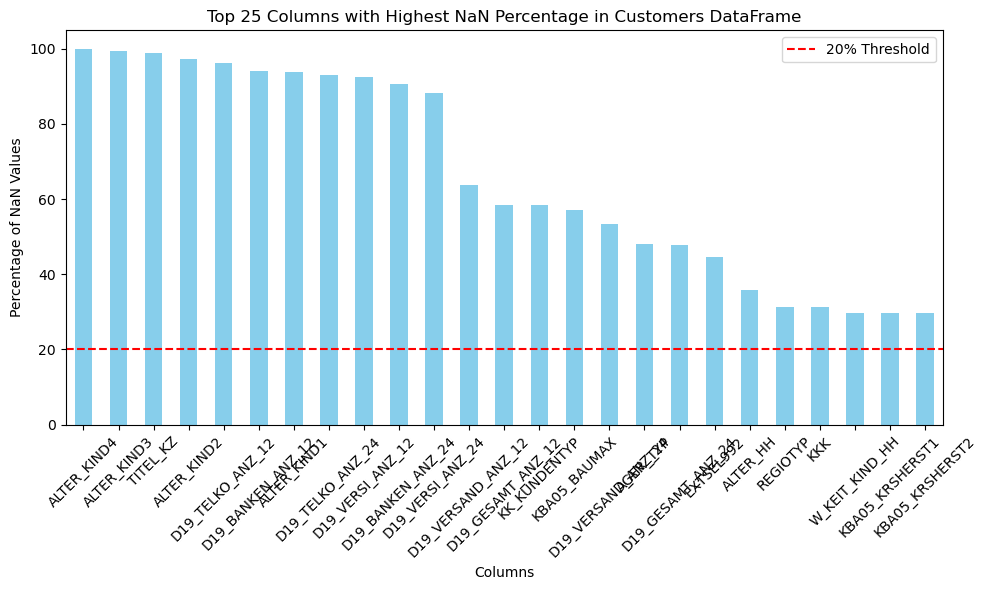

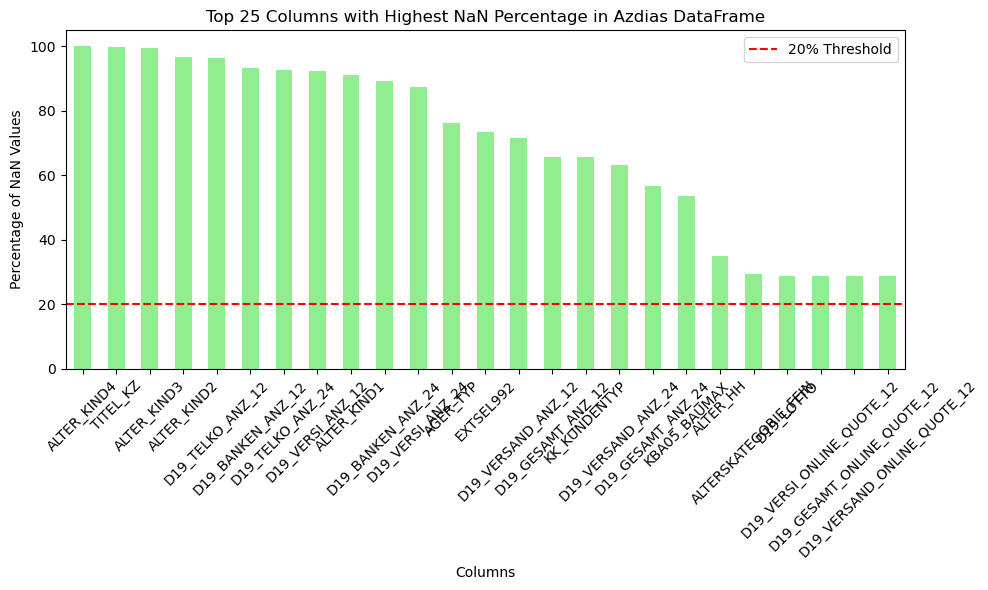

In [82]:

# Calculate the percentage of NaN values per column for azdias_without_duplicates
azdias_nan_percent = azdias_without_duplicates.isna().mean() * 100

# Calculate the percentage of NaN values per column for customers_without_duplicates
customers_nan_percent = customers_without_duplicates.isna().mean() * 100

# Plot the top 25 columns with the highest NaN percentages for customers_without_duplicates
top_25_customers_nan = customers_nan_percent.sort_values(ascending=False).head(25)
plt.figure(figsize=(10, 6))
top_25_customers_nan.plot(kind='bar', color='skyblue')
plt.axhline(y=20, color='red', linestyle='--', label='20% Threshold')
plt.title('Top 25 Columns with Highest NaN Percentage in Customers DataFrame')
plt.ylabel('Percentage of NaN Values')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot the top 25 columns with the highest NaN percentages for azdias_without_duplicates
top_25_azdias_nan = azdias_nan_percent.sort_values(ascending=False).head(25)
plt.figure(figsize=(10, 6))
top_25_azdias_nan.plot(kind='bar', color='lightgreen')
plt.axhline(y=20, color='red', linestyle='--', label='20% Threshold')
plt.title('Top 25 Columns with Highest NaN Percentage in Azdias DataFrame')
plt.ylabel('Percentage of NaN Values')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


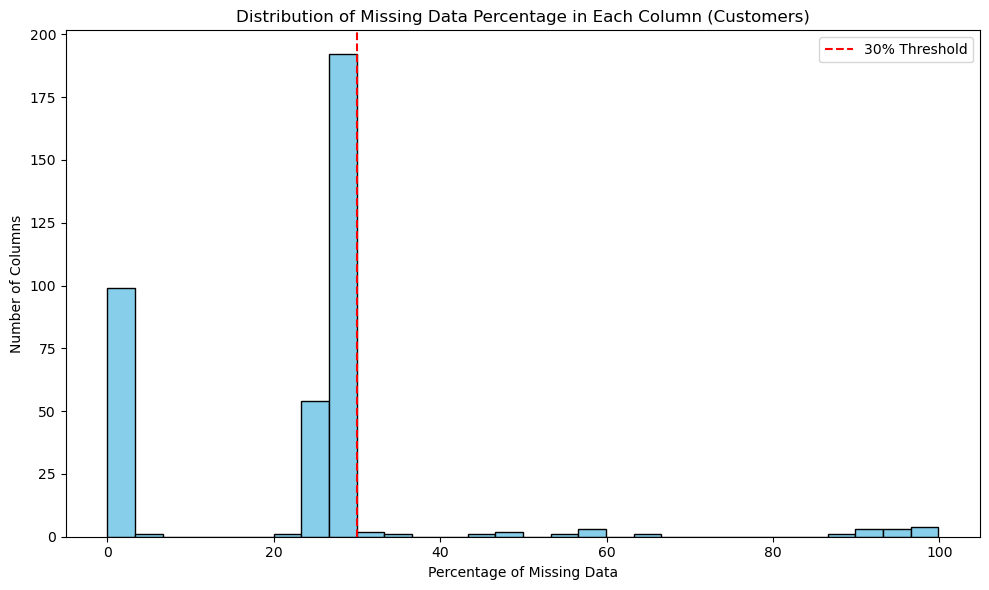

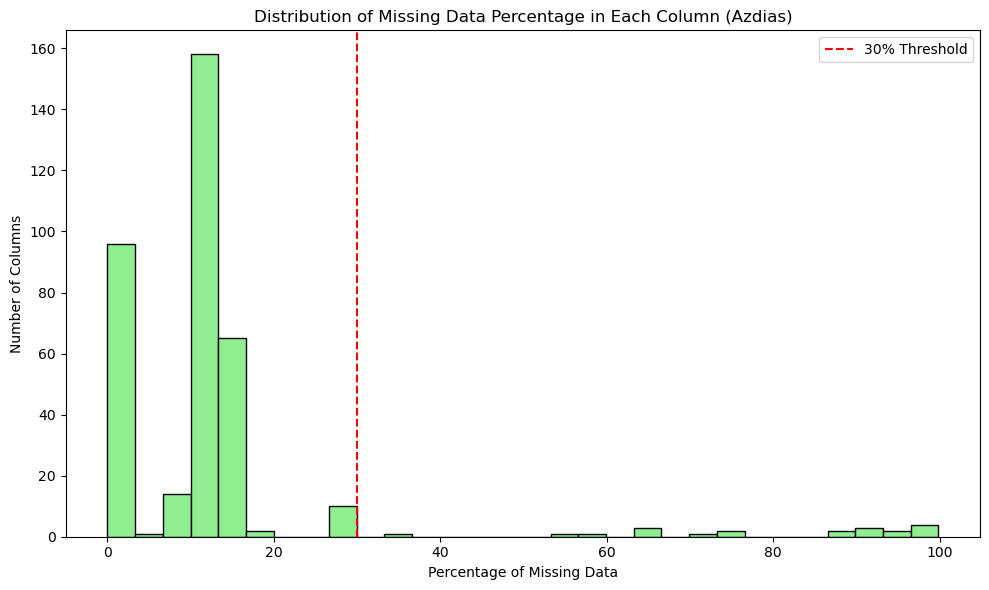

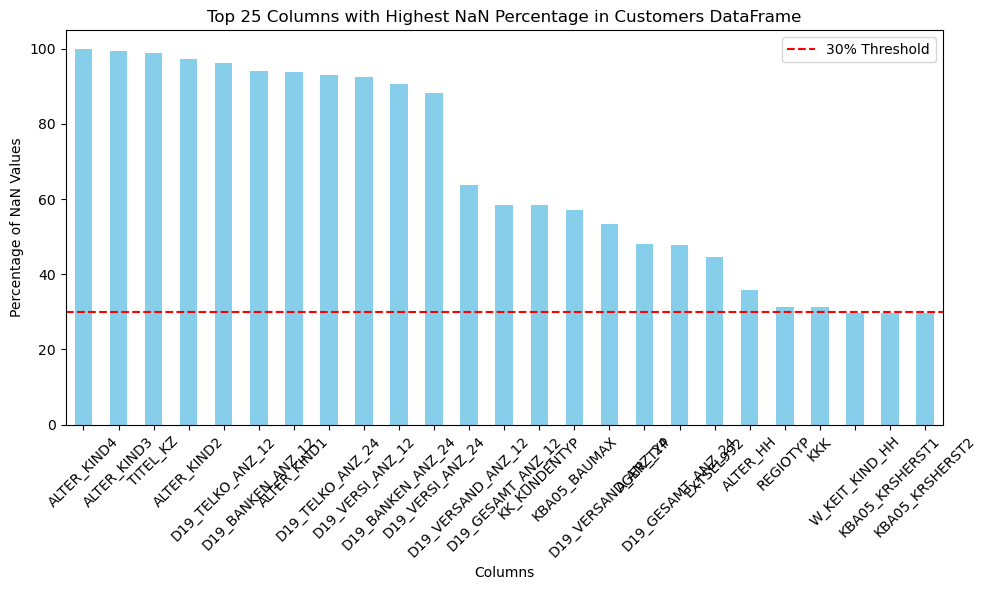

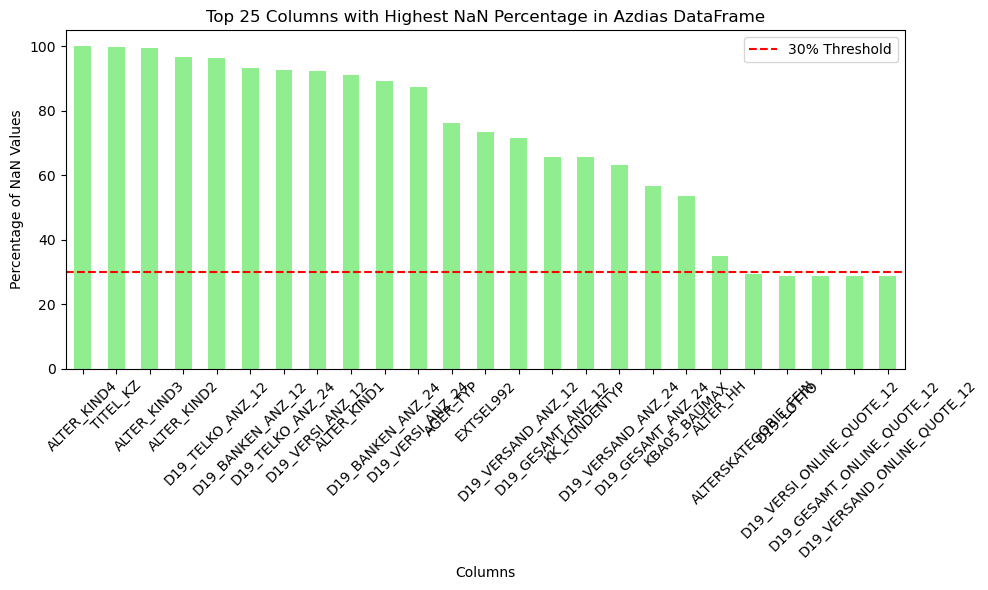

In [83]:
# Calculate the percentage of NaN values per column for azdias_without_duplicates
azdias_nan_percent = azdias_without_duplicates.isna().mean() * 100

# Calculate the percentage of NaN values per column for customers_without_duplicates
customers_nan_percent = customers_without_duplicates.isna().mean() * 100

# Plot the distribution of NaN percentages for customers_without_duplicates
plt.figure(figsize=(10, 6))
customers_nan_percent.plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=30, color='red', linestyle='--', label='30% Threshold')
plt.title('Distribution of Missing Data Percentage in Each Column (Customers)')
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Number of Columns')
plt.legend()
plt.tight_layout()
plt.show()

# Plot the distribution of NaN percentages for azdias_without_duplicates
plt.figure(figsize=(10, 6))
azdias_nan_percent.plot(kind='hist', bins=30, color='lightgreen', edgecolor='black')
plt.axvline(x=30, color='red', linestyle='--', label='30% Threshold')
plt.title('Distribution of Missing Data Percentage in Each Column (Azdias)')
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Number of Columns')
plt.legend()
plt.tight_layout()
plt.show()

# Plot the top 25 columns with the highest NaN percentages for customers_without_duplicates
top_25_customers_nan = customers_nan_percent.sort_values(ascending=False).head(25)
plt.figure(figsize=(10, 6))
top_25_customers_nan.plot(kind='bar', color='skyblue')
plt.axhline(y=30, color='red', linestyle='--', label='30% Threshold')
plt.title('Top 25 Columns with Highest NaN Percentage in Customers DataFrame')
plt.ylabel('Percentage of NaN Values')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot the top 25 columns with the highest NaN percentages for azdias_without_duplicates
top_25_azdias_nan = azdias_nan_percent.sort_values(ascending=False).head(25)
plt.figure(figsize=(10, 6))
top_25_azdias_nan.plot(kind='bar', color='lightgreen')
plt.axhline(y=30, color='red', linestyle='--', label='30% Threshold')
plt.title('Top 25 Columns with Highest NaN Percentage in Azdias DataFrame')
plt.ylabel('Percentage of NaN Values')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Für das Unsupervised Learning Modell wollen wir wissen, welche Spalten in den Datasets azdias_without_duplicates und customers_without_duplicates jeweils über 30% Missing Values haben  
 UND Welche dieser Spalten in allen beiden Datasets vorkommen.  
  
Dazu schreiben wir eine Funktion, die zwei Datasets entgegennimmt und dann die Spalten Printet, die in beiden Datasets vorkommen und dort jeweils über 30% Missing Values haben.


In [84]:
def find_common_high_missing_columns(df1, df2, threshold=30):
    """
    Finds columns with more than the specified threshold of missing values in both dataframes.

    Parameters:
    df1 (pd.DataFrame): First DataFrame.
    df2 (pd.DataFrame): Second DataFrame.
    threshold (float): Percentage threshold for missing values (default is 30).

    Returns:
    set: Columns that have more than the specified threshold of missing values in both dataframes.
    """
    # Calculate the percentage of missing values for each column
    missing_df1 = df1.isna().mean() * 100
    missing_df2 = df2.isna().mean() * 100

    # Find columns exceeding the missing value threshold
    high_missing_df1 = set(missing_df1[missing_df1 > threshold].index)
    high_missing_df2 = set(missing_df2[missing_df2 > threshold].index)

    # Find common columns with high missing values
    common_high_missing = high_missing_df1.intersection(high_missing_df2)

    return common_high_missing


In [85]:
# Example usage with DataFrames azdias_without_duplicates and customers_without_duplicates
common_columns = find_common_high_missing_columns(azdias_without_duplicates, customers_without_duplicates)
print(f"Columns with more than 30% missing values in both datasets: {common_columns}")

Columns with more than 30% missing values in both datasets: {'D19_BANKEN_ANZ_12', 'TITEL_KZ', 'D19_BANKEN_ANZ_24', 'ALTER_KIND1', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_VERSI_ANZ_24', 'EXTSEL992', 'D19_GESAMT_ANZ_12', 'AGER_TYP', 'D19_VERSAND_ANZ_12', 'ALTER_HH', 'D19_GESAMT_ANZ_24', 'ALTER_KIND3', 'D19_VERSAND_ANZ_24', 'KBA05_BAUMAX', 'ALTER_KIND4', 'ALTER_KIND2', 'D19_VERSI_ANZ_12', 'KK_KUNDENTYP'}


Jetzt entfernen wir die gemeinsamen Spalten mit über 30% Missing Values, die in den beiden Datasets azdias_without_duplicates, customers_without_duplicates vorkommen.

In [86]:
def remove_common_high_missing_columns(df1, df2, common_columns):
    """
    Remove columns from both dataframes that are present in the common_columns list.

    INPUT:
    df1 - (pandas DataFrame) first dataframe
    df2 - (pandas DataFrame) second dataframe
    common_columns - (list) list of column names to remove from both dataframes

    OUTPUT:
    df1_clean - (pandas DataFrame) first dataframe with common columns removed
    df2_clean - (pandas DataFrame) second dataframe with common columns removed
    """
    df1_clean = df1.drop(columns=common_columns, errors='ignore')
    df2_clean = df2.drop(columns=common_columns, errors='ignore')
    
    return df1_clean, df2_clean


In [87]:
# Assuming azdias_without_duplicates and customers_without_duplicates are your dataframes
# and common_columns is the list of columns with high missing values in both.
azdias_clean, customers_clean = remove_common_high_missing_columns(azdias_without_duplicates, customers_without_duplicates, common_columns)

Ermittlung, ob es noch Spalten mit verschidenen Datentypen gibt --> Angleichen für Training 

In [88]:
data_types = azdias_clean.dtypes

data_type_counts = data_types.value_counts()

print("Number of features for each data type in azdias_clean:")
print(data_type_counts)

Number of features for each data type in azdias_clean:
float64    263
int64       77
object       6
Name: count, dtype: int64


In [89]:
data_types = customers_clean.dtypes

data_type_counts = data_types.value_counts()

print("Number of features for each data type in customers_clean:")
print(data_type_counts)

Number of features for each data type in customers_clean:
float64    263
int64       78
object       8
Name: count, dtype: int64


In [90]:
#print object-type columns in azdias_clean
for column in azdias_clean.columns:
    if azdias_clean[column].dtype == 'object':
        print(column)


CAMEO_DEU_2015
CAMEO_DEUG_2015
CAMEO_INTL_2015
D19_LETZTER_KAUF_BRANCHE
EINGEFUEGT_AM
OST_WEST_KZ


In [91]:
#print object-type columns in customers_clean
for column in customers_clean.columns:
    if customers_clean[column].dtype == 'object':
        print(column)

CAMEO_DEU_2015
CAMEO_DEUG_2015
CAMEO_INTL_2015
D19_LETZTER_KAUF_BRANCHE
EINGEFUEGT_AM
OST_WEST_KZ
PRODUCT_GROUP
CUSTOMER_GROUP


In [92]:
print(customers_clean['CAMEO_INTL_2015'].head())
print(azdias_clean['CAMEO_INTL_2015'].head())

0    13.0
1     NaN
2    34.0
3    24.0
4    41.0
Name: CAMEO_INTL_2015, dtype: object
0     NaN
1    51.0
2    24.0
3    12.0
4    43.0
Name: CAMEO_INTL_2015, dtype: object


Als nächsten Schritt schreiben wir einen Mapper, um die Object-Columns auf nummerische Werte zu mappen

Die Funktion soll ein Dataset entgegennehmen und auf die oben definierten Object-Spalten untersuchen.

Wenn die jeweiligen Spalten im Dataset vorhanden sind, sollen deren Werte auf entsprechende nummerische Werte analog des Mappers umgewandelt werden.  
  
Folgende Spalten sind Datentyp object, können aber 1 zu 1 in Integer umgewandelt werde, weil sie schon nummerische Werte enthalten:
CAMEO_DEUG_2015
CAMEO_INTL_2015
  
D19_LETZTER_KAUF_BRANCHE --> Muss entfernt werden, da kein Mapping in DIAS Attributes - Values 2017  
EINGEFUEGT_AM --> Muss entfernt werden, da kein Mapping in DIAS Attributes - Values 2017  



In [93]:
#Mapper for Column CAMEO_DEU_2015
CAMEO_DEU_2015_mapping = {
    "1A": 1,
    "1B": 2,
    "1C": 3,
    "1D": 4,
    "1E": 5,
    "2A": 6,
    "2B": 7,
    "2C": 8,
    "2D": 9,
    "3A": 10,
    "3B": 11,
    "3C": 12,
    "3D": 13,
    "4A": 14,
    "4B": 15,
    "4C": 16,
    "4D": 17,
    "4E": 18,
    "5A": 19,
    "5B": 20,
    "5C": 21,
    "5D": 22,
    "5E": 23,
    "5F": 24,
    "6A": 25,
    "6B": 26,
    "6C": 27,
    "6D": 28,
    "6E": 29,
    "6F": 30,
    "7A": 31,
    "7B": 32,
    "7C": 33,
    "7D": 34,
    "7E": 35,
    "8A": 36,
    "8B": 37,
    "8C": 38,
    "8D": 39,
    "9A": 40,
    "9B": 41,
    "9C": 42,
    "9D": 43,
    "9E": 44,
    "XX": np.nan, #unknown
}

OST_WEST_KZ_mapping = {
    "O": 1, #East
    "W": 2 #West
}

Die folgende Funktion führt folgende Schritte aus:

Prüfen ob Spalten 'D19_LETZTER_KAUF_BRANCHE' und 'EINGEFUEGT_AM' vorhanden  
Wenn ja: Spalten Entfernen  
  
Prüfen ob Spalten 'CAMEO_DEU_2015' und 'OST_WEST_KZ' vorhanden  
Wenn ja: Mapping auf CAMEO_DEU_2015_mapping und OST_WEST_KZ_mapping  
  
Prüfe ob Spalten CAMEO_DEUG_2015 und CAMEO_INTL_2015 vorhanden sind  
Wenn ja: Werte als Integer konvertieren (Vorher prüfen ob alle Werte Zahlen, wenn zB 'XX' vorhanden, diesen Wert als NaN ersetzen)

In [94]:
def process_dataframe(df, cameo_deu_2015_mapping, ost_west_kz_mapping):
    """
    Processes the given DataFrame by performing the following steps:
    - Checks for specific columns and removes them if they exist.
    - Maps values for specified columns using provided mappings.
    - Replaces non-numeric values with NaN before converting specific columns to integers.
    - Converts specific columns to integers if they exist.

    INPUT:
    df - The input DataFrame to process.
    cameo_deu_2015_mapping - A dictionary for mapping 'CAMEO_DEU_2015' column values.
    ost_west_kz_mapping - A dictionary for mapping 'OST_WEST_KZ' column values.

    OUTPUT:
    df - The processed DataFrame.
    """
    
    # Check and remove columns if they exist
    columns_to_remove = ['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']
    for col in columns_to_remove:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)
            print(f"Column {col} removed.")
    
    # Check for columns and apply mappings if they exist
    if 'CAMEO_DEU_2015' in df.columns:
        df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace(cameo_deu_2015_mapping)
        print("CAMEO_DEU_2015 column mapped.")
    
    if 'OST_WEST_KZ' in df.columns:
        df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace(ost_west_kz_mapping)
        print("OST_WEST_KZ column mapped.")
    
    # Check and replace non-numeric values before converting to integers
    columns_to_convert = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    for col in columns_to_convert:
        if col in df.columns:
            # Replace non-numeric values with NaN
            df[col] = pd.to_numeric(df[col], errors='coerce')
            print(f"Non-numeric values in column {col} replaced with NaN.")
            
            # Convert the column to integer type
            df[col] = df[col].astype('Int64')
            print(f"Column {col} converted to integer.")
    
    return df


In [95]:
# Function Trigger for azdias_clean 
azdias_clean_object_remove = process_dataframe(azdias_clean, CAMEO_DEU_2015_mapping, OST_WEST_KZ_mapping)

Column D19_LETZTER_KAUF_BRANCHE removed.
Column EINGEFUEGT_AM removed.


C:\Users\GSQOQWI\AppData\Local\Temp\1\ipykernel_23476\3496442854.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace(cameo_deu_2015_mapping)


CAMEO_DEU_2015 column mapped.


C:\Users\GSQOQWI\AppData\Local\Temp\1\ipykernel_23476\3496442854.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace(ost_west_kz_mapping)


OST_WEST_KZ column mapped.
Non-numeric values in column CAMEO_DEUG_2015 replaced with NaN.
Column CAMEO_DEUG_2015 converted to integer.
Non-numeric values in column CAMEO_INTL_2015 replaced with NaN.
Column CAMEO_INTL_2015 converted to integer.


In [96]:
# Function Trigger for customers_clean 
customers_clean_object_remove = process_dataframe(customers_clean, CAMEO_DEU_2015_mapping, OST_WEST_KZ_mapping)

Column D19_LETZTER_KAUF_BRANCHE removed.
Column EINGEFUEGT_AM removed.


C:\Users\GSQOQWI\AppData\Local\Temp\1\ipykernel_23476\3496442854.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace(cameo_deu_2015_mapping)
C:\Users\GSQOQWI\AppData\Local\Temp\1\ipykernel_23476\3496442854.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace(ost_west_kz_mapping)


CAMEO_DEU_2015 column mapped.
OST_WEST_KZ column mapped.
Non-numeric values in column CAMEO_DEUG_2015 replaced with NaN.
Column CAMEO_DEUG_2015 converted to integer.
Non-numeric values in column CAMEO_INTL_2015 replaced with NaN.
Column CAMEO_INTL_2015 converted to integer.


In [97]:
#check object removal:

data_types = azdias_clean_object_remove.dtypes

data_type_counts = data_types.value_counts()

print("Number of features for each data type in azdias_clean_object_remove:")
print(data_type_counts)

#print object-type columns in customers_clean
for column in azdias_clean_object_remove.columns:
    if azdias_clean_object_remove[column].dtype == 'object':
        print(column)

Number of features for each data type in azdias_clean_object_remove:
float64    265
int64       77
Int64        2
Name: count, dtype: int64


In [98]:
print(azdias_clean_object_remove['CAMEO_DEU_2015'].unique())

[nan 36. 16.  6. 26. 38. 14.  9.  1.  5. 43. 21. 37. 31. 22. 44. 41.  2.
 13. 18. 15. 12. 19. 32. 40. 28. 29.  8. 33. 42. 34. 23.  4. 39. 27. 25.
 20. 17. 10.  7. 35. 11. 30. 24.  3.]


In [99]:
print(azdias_clean_object_remove['CAMEO_DEU_2015'].unique())

[nan 36. 16.  6. 26. 38. 14.  9.  1.  5. 43. 21. 37. 31. 22. 44. 41.  2.
 13. 18. 15. 12. 19. 32. 40. 28. 29.  8. 33. 42. 34. 23.  4. 39. 27. 25.
 20. 17. 10.  7. 35. 11. 30. 24.  3.]


Jetzt bietet es sich an, alle Spalten in den Datentyp Int64 umzuwandeln.

In [100]:
def convert_columns_to_int(df):
    """
    Converts all columns in the given DataFrame to Int64 data type without replacing NaN values.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    
    Returns:
    pd.DataFrame: The DataFrame with all numeric columns converted to Int64.
    """
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            # Convert the column to Int64 type without filling NaN values
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
    
    return df

In [101]:
# Convert all Columns to Int64 and Replace all NaN with Median - Dataframe azdias_clean_object_remove
azdias_final = convert_columns_to_int(azdias_clean_object_remove)
print(azdias_final.head(10))
print(azdias_final.dtypes.value_counts())

      LNR  AKT_DAT_KL  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0  910215        <NA>                  <NA>                 <NA>   
1  910220           9                    21                   11   
2  910225           9                    17                   10   
3  910226           1                    13                    1   
4  910241           1                    14                    3   
5  910244           1                    10                    5   
6  910248           9                  <NA>                    4   
7  910261           1                    14                    6   
8  645145           9                    16                    2   
9  645153           5                    17                    9   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0          <NA>        <NA>          <NA>                        <NA>   
1             0           0             2                          12   
2             0           0     

In [102]:
# Convert all Columns to Int64 and Replace all NaN with Median - Dataframe customers_clean_object_remove
customers_final = convert_columns_to_int(customers_clean_object_remove)
print(customers_final.head(10))
print(customers_final.dtypes.value_counts())


      LNR  AKT_DAT_KL  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0    9626           1                    10                    1   
1    9628           9                  <NA>                 <NA>   
2  143872           1                     0                    1   
3  143873           1                     8                    0   
4  143874           1                    14                    7   
5  143888           1                    10                    1   
6  143904           1                    10                    1   
7  143910           1                     9                    1   
8  102160           3                     4                   74   
9  102173           1                    13                    1   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0             0           0             2                           1   
1          <NA>           0             3                        <NA>   
2             0           0     

Notiz:

Next Steps: 
Spalten ü20% Droppen
Andere NaNs durch Median ergänzen

Multi Categorial Columns Mappen
ggf. die zusätzliche Column in Customers droppen fürs Modell 

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [103]:
#drop the additional object-columns in customers_cleaned-Dataframe before scaling

# Assuming customers_cleaned and azdias_cleaned are already defined DataFrames

# Find columns that are present in customers_cleaned but not in azdias_cleaned
unique_columns_customers = set(customers_final.columns)
unique_columns_azdias = set(azdias_final.columns)

# Identify the columns that are only present in customers_cleaned
diff_columns = unique_columns_customers - unique_columns_azdias

# Print the columns that are only present in customers_cleaned
print("Columns present in customers_cleaned but not in azdias_cleaned:")
print(diff_columns)

# Drop the columns in diff_columns from customers_final
customers_final = customers_final.drop(columns=diff_columns)

print(f'Columns {diff_columns} dropped')


Columns present in customers_cleaned but not in azdias_cleaned:
{'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'}
Columns {'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'} dropped


In [104]:
from sklearn.impute import SimpleImputer

#Use SimpleImputer to replace missing Values with median
imputer = SimpleImputer(strategy='median')
#replace nan with median
azdias_final_imputed = imputer.fit_transform(azdias_final)

In [105]:
customers_final_imputed = imputer.transform(customers_final)

In [106]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
azdias_scaled_data = scaler.fit_transform(azdias_final_imputed)

# check shape after scaling azdias
print("Shape after scaling:", azdias_scaled_data.shape)

Shape after scaling: (891221, 344)


In [107]:
customers_scaled_data = scaler.fit_transform(customers_final_imputed)

# check shape after scaling customers
print("Shape after scaling customers:", customers_scaled_data.shape)

Shape after scaling customers: (191652, 344)


In [108]:
# check if there are NaN- or infinity values - azdias
print("Anzahl der NaN-Werte:", np.isnan(azdias_scaled_data).sum())
print("Anzahl der unendlichen Werte:", np.isinf(azdias_scaled_data).sum())

Anzahl der NaN-Werte: 0
Anzahl der unendlichen Werte: 0


In [109]:
# check if there are NaN- or infinity values - customers
print("Anzahl der NaN-Werte:", np.isnan(customers_scaled_data).sum())
print("Anzahl der unendlichen Werte:", np.isinf(customers_scaled_data).sum())

Anzahl der NaN-Werte: 0
Anzahl der unendlichen Werte: 0


In [110]:
# Apply PCA to the data -azdias
from sklearn.decomposition import PCA

pca = PCA()  
pca.fit(azdias_scaled_data)  # Fit PCA on scaled data

PCA()

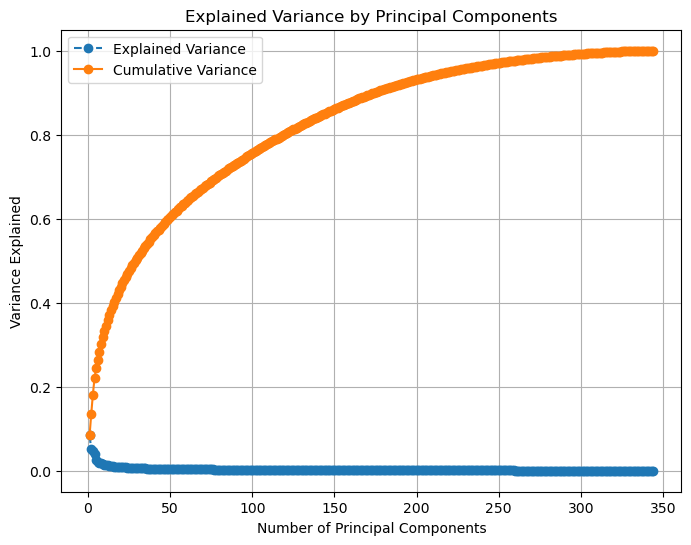

Number of components to explain 90% of variance: 175


In [111]:
# Investigate the variance accounted for by each principal component.

# Schritt 1: Berechne die Varianz, die durch jede Hauptkomponente erklärt wird
explained_variance_ratio = pca.explained_variance_ratio_

# Schritt 2: Berechne die kumulative Varianz
cumulative_variance = np.cumsum(explained_variance_ratio)

# Schritt 3: Plot der Varianz und kumulativen Varianz
plt.figure(figsize=(8, 6))

# Plot der Varianz, die jede Komponente erklärt
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', label='Explained Variance')

# Plot der kumulativen Varianz
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', label='Cumulative Variance')

# Beschriftung der Achsen und Titel
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Principal Components')

# Legende und Gitter hinzufügen
plt.legend()
plt.grid(True)
plt.show()

# Optional: Bestimme die Anzahl der Komponenten, um z.B. 90% der Varianz zu erklären
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f'Number of components to explain 90% of variance: {n_components_90}')

In [112]:
# Apply PCA with the selected number of components
pca = PCA(n_components=n_components_90)
azdias_pca = pca.fit_transform(azdias_scaled_data)
customers_pca = pca.transform(customers_scaled_data)  # Apply the same PCA transformation

# Output for verification
print("Shape of PCA-transformed azdias data:", azdias_pca.shape)
print("Shape of PCA-transformed customers data:", customers_pca.shape)

Shape of PCA-transformed azdias data: (891221, 175)
Shape of PCA-transformed customers data: (191652, 175)


Clustering zur Gruppenerkennung  

Wende ein Clustering-Verfahren wie KMeans an, um Cluster in den PCA-transformierten Daten zu identifizieren. Dies hilft dabei, Gruppen von Merkmalen zu erkennen, die potenziell im  
 customers-Datensatz überrepräsentiert sind.

In [113]:
from sklearn.cluster import KMeans

# Apply KMeans on the PCA-transformed azdias data
kmeans = KMeans(n_clusters=5, random_state=42)  # You can adjust the number of clusters
azdias_labels = kmeans.fit_predict(azdias_pca)

# Apply KMeans on the customers data (using the previously trained cluster centers)
customers_labels = kmeans.predict(customers_pca)

Analyse der Cluster-Zusammensetzung  

Vergleiche die Cluster-Zusammensetzungen der beiden Datensätze, um festzustellen, welche Cluster in den customers-Daten im Vergleich zur Gesamtbevölkerung (azdias) häufiger vertreten sind.

In [114]:
# Distribution of clusters in both datasets
azdias_cluster_counts = np.bincount(azdias_labels)
customers_cluster_counts = np.bincount(customers_labels)

# Normalize for comparison
azdias_cluster_distribution = azdias_cluster_counts / len(azdias_labels)
customers_cluster_distribution = customers_cluster_counts / len(customers_labels)

# Compare the distributions
cluster_difference = customers_cluster_distribution - azdias_cluster_distribution

Visualisierung der Ergebnisse  
Erstelle Plots, um die Unterschiede in den Cluster-Zusammensetzungen zu visualisieren. Dies könnte ein Balkendiagramm der Cluster-Verteilungen sein.

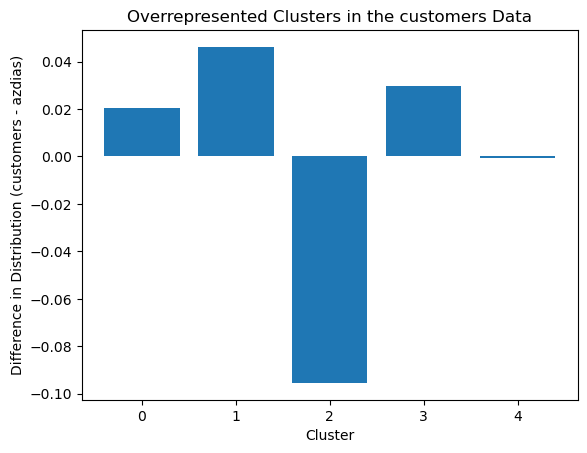

In [115]:
# Bar chart of the distributions
plt.bar(range(len(cluster_difference)), cluster_difference)
plt.xlabel('Cluster')
plt.ylabel('Difference in Distribution (customers - azdias)')
plt.title('Overrepresented Clusters in the customers Data')
plt.show()


Feature-Analyse innerhalb der Cluster  
Um zu verstehen, welche Features in einem bestimmten Cluster dominieren, kannst du die Merkmale untersuchen, die am stärksten zu den Hauptkomponenten beitragen, die diese Cluster repräsentieren.



In [116]:
# Beitrag der Features zur ersten Hauptkomponente (als Beispiel)
feature_contributions = pca.components_[0]  # Erste Hauptkomponente
top_features_indices = np.argsort(np.abs(feature_contributions))[-10:]  # Top 10 Merkmale
top_features = azdias_clean_object_remove.columns[top_features_indices]
print("Top contributing features:", top_features)

Top contributing features: Index(['MOBI_RASTER', 'PLZ8_ANTG4', 'CAMEO_DEUG_2015', 'KBA13_ANTG4',
       'CAMEO_DEU_2015', 'PLZ8_ANTG3', 'KBA13_ANTG3', 'KBA13_ANTG1',
       'PLZ8_ANTG1', 'MOBI_REGIO'],
      dtype='object')



Um herauszufinden, welche Features am meisten zu einem bestimmten Cluster beitragen und in welcher Höhe, kannst du die Ladungen der Hauptkomponenten (PCA-Components) analysieren. Diese Ladungen zeigen, wie stark jedes Feature zu den einzelnen Hauptkomponenten beiträgt. Da du PCA verwendet hast, sind die ursprünglichen Features in die Hauptkomponenten "transformiert", und jedes Cluster wird von verschiedenen Hauptkomponenten charakterisiert.

1. Berechne die Cluster-Zentren im PCA-Raum  
Da du KMeans angewendet hast, gibt es für jedes Cluster einen Cluster-Zentrumspunkt im PCA-Raum. Die Position dieses Zentrums zeigt, wie stark jede Hauptkomponente in diesem Cluster gewichtet ist.

In [119]:
# Get the cluster centers in the PCA space
cluster_centers_pca = kmeans.cluster_centers_

2. Identifiziere die wichtigsten Hauptkomponenten für jedes Cluster  
Die Werte im cluster_centers_pca-Array geben an, wie stark jede Hauptkomponente zu einem bestimmten Clusterzentrum beiträgt. Größere Werte für eine Hauptkomponente bedeuten, dass diese Komponente für dieses Cluster wichtig ist.

In [121]:
# Find the top principal components for Cluster 1
cluster_1_center = cluster_centers_pca[1]
top_pcs_indices = np.argsort(np.abs(cluster_1_center))[-5:]  # Get top 5 components
print("Top principal components for Cluster 0:", top_pcs_indices)


Top principal components for Cluster 0: [10  1  3  0  2]


3. Analysiere die wichtigsten Features pro Hauptkomponente  
Jetzt, da du die wichtigsten Hauptkomponenten für ein Cluster (z.B., Cluster 1) identifiziert hast, kannst du herausfinden, welche ursprünglichen Features am meisten zu diesen Hauptkomponenten beitragen. Die PCA-Ladungen (Werte in pca.components_) geben die Gewichte der ursprünglichen Features für jede Hauptkomponente an.

In [124]:
# Dictionary to store top positive features for each cluster
cluster_top_features = {}

# Iterate through each cluster's top principal components
for cluster_index in range(n_clusters):  # Assuming you have n_clusters defined
    # Get the cluster center in the PCA space for the specified cluster
    cluster_center = cluster_centers_pca[cluster_index]
    
    # Find the indices of the top principal components that contribute the most to this cluster
    top_n_components = 5  # Number of top principal components to consider
    top_pcs_indices = np.argsort(np.abs(cluster_center))[-top_n_components:]  # Get top N components
    
    # List to store top features for the current cluster
    top_features_for_cluster = []
    
    # Loop through each of these top principal components and find the top contributing positive features
    for pc_index in top_pcs_indices:
        # Get the loadings of the original features for this principal component
        component_loadings = pca.components_[pc_index]
        
        # Filter only positive contributions
        positive_indices = np.where(component_loadings > 0)[0]
        positive_contributions = component_loadings[positive_indices]
        
        # Find the indices of the top 5 positive features
        top_positive_indices = np.argsort(positive_contributions)[-5:]  # Top 5 positive features
        top_features = azdias_final.columns[positive_indices[top_positive_indices]]
        top_contributions = positive_contributions[top_positive_indices]
        
        # Append top features and contributions for this principal component to the list
        top_features_for_cluster.extend(zip(top_features, top_contributions))
    
    # Save the list of top features for this cluster in the dictionary
    cluster_top_features[cluster_index] = top_features_for_cluster

# Display the top features for each cluster
for cluster, features in cluster_top_features.items():
    print(f"Top positive features for Cluster {cluster}:")
    for feature, contribution in features:
        print(f"Feature: {feature}, Contribution: {contribution}")
    print("\n")  # Newline for readability

# Now `cluster_top_features` dictionary contains the top positive features for each cluster


Top positive features for Cluster 0:
Feature: KBA13_KMH_110, Contribution: 0.10211481801070202
Feature: KBA13_KW_30, Contribution: 0.103767620773508
Feature: KBA13_HALTER_66, Contribution: 0.10984890978725681
Feature: KBA13_ALTERHALTER_61, Contribution: 0.11373420506950928
Feature: HH_EINKOMMEN_SCORE, Contribution: 0.1637327159776431
Feature: KBA05_MAXSEG, Contribution: 0.12755164878877318
Feature: SEMIO_FAM, Contribution: 0.15589898569018254
Feature: SEMIO_SOZ, Contribution: 0.17797768340001216
Feature: SEMIO_KULT, Contribution: 0.19640295878087122
Feature: SEMIO_VERT, Contribution: 0.2060228382465562
Feature: CJT_TYP_2, Contribution: 0.1329176509134459
Feature: D19_VERSAND_ONLINE_QUOTE_12, Contribution: 0.1338308562425856
Feature: D19_GESAMT_ONLINE_QUOTE_12, Contribution: 0.13769702449873347
Feature: ONLINE_AFFINITAET, Contribution: 0.15792548297683645
Feature: PRAEGENDE_JUGENDJAHRE, Contribution: 0.16025300102004292
Feature: KBA05_ANTG1, Contribution: 0.1290643523474615
Feature: MOB

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [117]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\GSQOQWI\AppData\Local\Temp\1\ipykernel_23476\2624572247.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [118]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\GSQOQWI\AppData\Local\Temp\1\ipykernel_23476\4118961090.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
